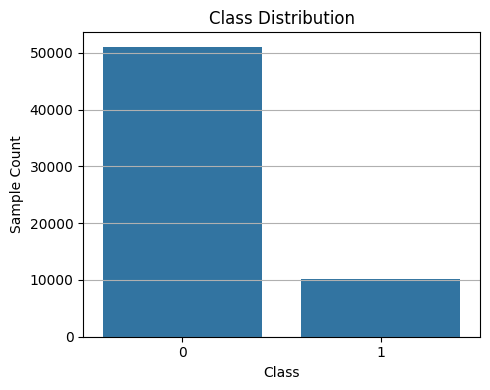

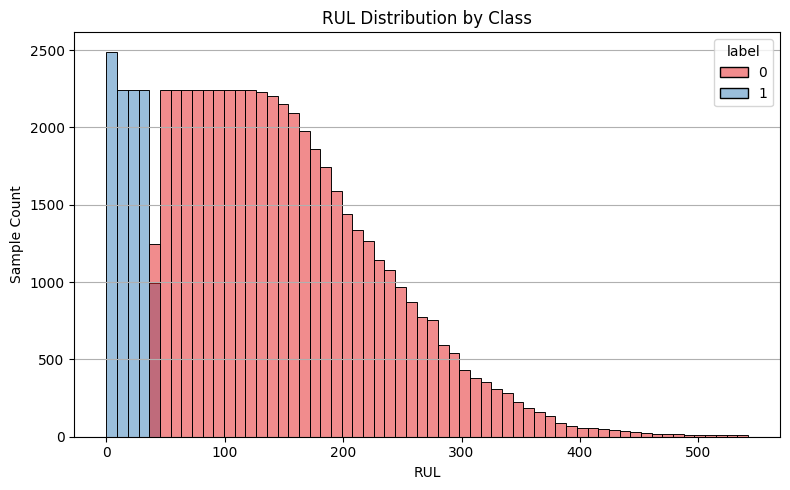

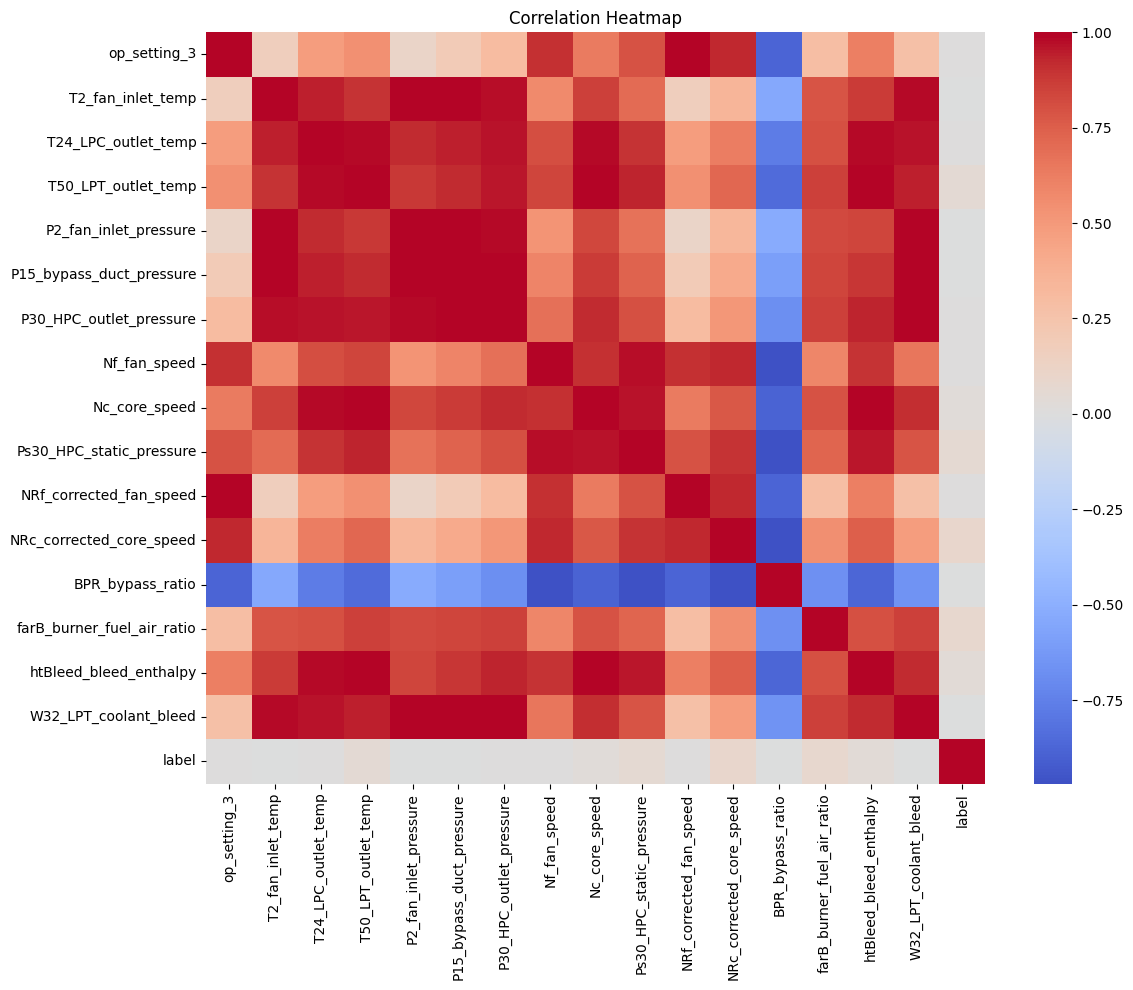

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('FD004_full_training_with_named_sensors (1).csv')

features = [
    'op_setting_3', 'T2_fan_inlet_temp', 'T24_LPC_outlet_temp', 'T50_LPT_outlet_temp',
    'P2_fan_inlet_pressure', 'P15_bypass_duct_pressure', 'P30_HPC_outlet_pressure',
    'Nf_fan_speed', 'Nc_core_speed', 'Ps30_HPC_static_pressure', 'NRf_corrected_fan_speed',
    'NRc_corrected_core_speed', 'BPR_bypass_ratio', 'farB_burner_fuel_air_ratio',
    'htBleed_bleed_enthalpy', 'W32_LPT_coolant_bleed'
]

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

if 'RUL' not in df.columns:
    rul_df = df.groupby('engine_id')['cycle'].max().reset_index()
    rul_df.columns = ['engine_id', 'max_cycle']
    df = df.merge(rul_df, on='engine_id')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df.drop('max_cycle', axis=1, inplace=True)

df['label'] = (df['RUL'] <= 40).astype(int)

plt.figure(figsize=(5, 4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='RUL', hue='label', bins=60, kde=False, palette='Set1')
plt.title('RUL Distribution by Class')
plt.xlabel('RUL')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
correlation = df[features + ['label']].corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [5]:
print("Head:")
print(df.head())

print("\n Tail:")
print(df.tail())

print("\n Summary:")
print(df.describe())

print("\n Structure:")
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print(df.dtypes)

print("\n Nulls and Unique values:")
for col in df.columns:
    print(f"{col}: {df[col].isnull().sum()} nulls, {df[col].nunique()} unique")

Head:
   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1       42.0049        0.8400           1.0   
1          1      2       20.0020        0.7002           1.0   
2          1      3       42.0038        0.8409           1.0   
3          1      4       42.0000        0.8400           1.0   
4          1      5       25.0063        0.6207           0.0   

   T2_fan_inlet_temp  T24_LPC_outlet_temp  T30_HPC_outlet_temp  \
0           0.000000             0.130347              1343.43   
1           0.626985             0.647971              1477.61   
2           0.000000             0.123646              1343.12   
3           0.000000             0.121351              1341.24   
4           0.238089             0.005691              1255.23   

   T50_LPT_outlet_temp  P2_fan_inlet_pressure  ...  BPR_bypass_ratio  \
0             0.212586               0.000000  ...          0.400540   
1             0.511781               0.507937  ...          0.

In [7]:
from sklearn.utils import class_weight
import numpy as np

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

class_weights = {i : w for i, w in enumerate(weights)}
print(class_weights)


{0: np.float64(0.6000097962382445), 1: np.float64(2.999755118033108)}


In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.1 MB/s eta 0:00:00


In [9]:
import numpy as np
import optuna
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam


def create_sequences(data, seq_len, features, label_col='label'):
    X, y = [], []
    for eid in data['engine_id'].unique():
        unit = data[data['engine_id'] == eid]
        for i in range(len(unit) - seq_len):
            X.append(unit[features].iloc[i:i+seq_len].values)
            y.append(unit[label_col].iloc[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(df, seq_len, features)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}


def objective(trial):
    model = Sequential()
    model.add(Conv1D(
        filters=trial.suggest_categorical("filters", [32, 64, 128]),
        kernel_size=trial.suggest_int("kernel_size", 2, 4),
        activation='relu',
        input_shape=(seq_len, X.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(trial.suggest_categorical("lstm_units", [32, 64, 128])))
    model.add(Dropout(trial.suggest_float("dropout", 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(trial.suggest_float("lr", 1e-4, 1e-2, log=True)),
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=trial.suggest_categorical("batch_size", [32, 64]),
        class_weight=class_weights,
        verbose=0
    )

    score = model.evaluate(X_val, y_val, verbose=0)
    return score[1]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)


best_params = study.best_trial.params
print("Best params:", best_params)


final_model = Sequential()
final_model.add(Conv1D(filters=best_params['filters'], kernel_size=best_params['kernel_size'],
                       activation='relu', input_shape=(seq_len, X.shape[2])))
final_model.add(MaxPooling1D(pool_size=2))
final_model.add(LSTM(best_params['lstm_units']))
final_model.add(Dropout(best_params['dropout']))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=best_params['lr']), metrics=['accuracy'])

final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=best_params['batch_size'],
    class_weight=class_weights,
    verbose=1
)

y_pred = (final_model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred))


[I 2025-05-17 09:22:38,187] A new study created in memory with name: no-name-2e19c74c-4cc3-4ab4-85ae-ca6cccec1f58
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-05-17 09:25:45,861] Trial 0 finished with value: 0.8978244662284851 and parameters: {'filters': 64, 'kernel_size': 4, 'lstm_units': 64, 'dropout': 0.32681451355280816, 'lr': 0.004556019650288, 'batch_size': 32}. Best is trial 0 with value: 0.8978244662284851.
[I 2025-05-17 09:27:13,511] Trial 1 finished with value: 0.824470043182373 and parameters: {'filters': 32, 'kernel_size': 2, 'lstm_units': 32, 'dropout': 0.2929300186697473, 'lr': 0.0003695944832846599, 'batch_size': 64}. Best is trial 0 with value: 0.8978244662284851.
[I 

Best params: {'filters': 128, 'kernel_size': 3, 'lstm_units': 128, 'dropout': 0.37982888792738395, 'lr': 0.0032489854095284487, 'batch_size': 32}
Epoch 1/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.6988 - loss: 0.5447 - val_accuracy: 0.8953 - val_loss: 0.2694
Epoch 2/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.8645 - loss: 0.3271 - val_accuracy: 0.8849 - val_loss: 0.2898
Epoch 3/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.8743 - loss: 0.3007 - val_accuracy: 0.9211 - val_loss: 0.1938
Epoch 4/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.8788 - loss: 0.2862 - val_accuracy: 0.9221 - val_loss: 0.1933
Epoch 5/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.8922 - loss: 0.2528 - val_accuracy: 0.9239 - val_loss: 0.1960
Epoch 6/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.8894 - loss: 0.2604 - val_accuracy: 0.8099 - val_loss: 0.4397
Epoch 7/20
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accu

In [10]:
final_model.save("best_cnn_lstm_model.h5")

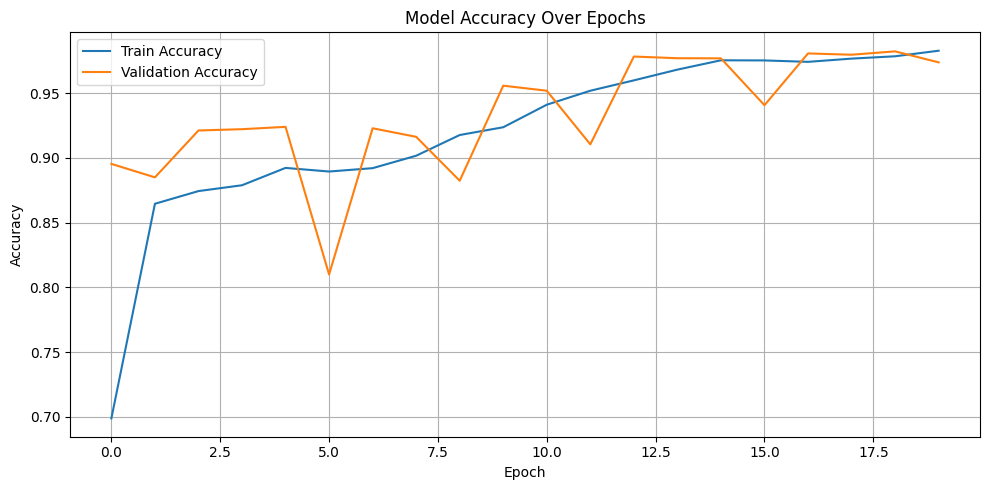

In [15]:
train_acc = [
    0.6988, 0.8645, 0.8743, 0.8788, 0.8922, 0.8894, 0.8920, 0.9016, 0.9176, 0.9236,
    0.9410, 0.9518, 0.9598, 0.9681, 0.9753, 0.9752, 0.9741, 0.9766, 0.9784, 0.9827
]
val_acc = [
    0.8953, 0.8849, 0.9211, 0.9221, 0.9239, 0.8099, 0.9228, 0.9162, 0.8823, 0.9557,
    0.9518, 0.9104, 0.9782, 0.9769, 0.9768, 0.9406, 0.9806, 0.9796, 0.9822, 0.9737
]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


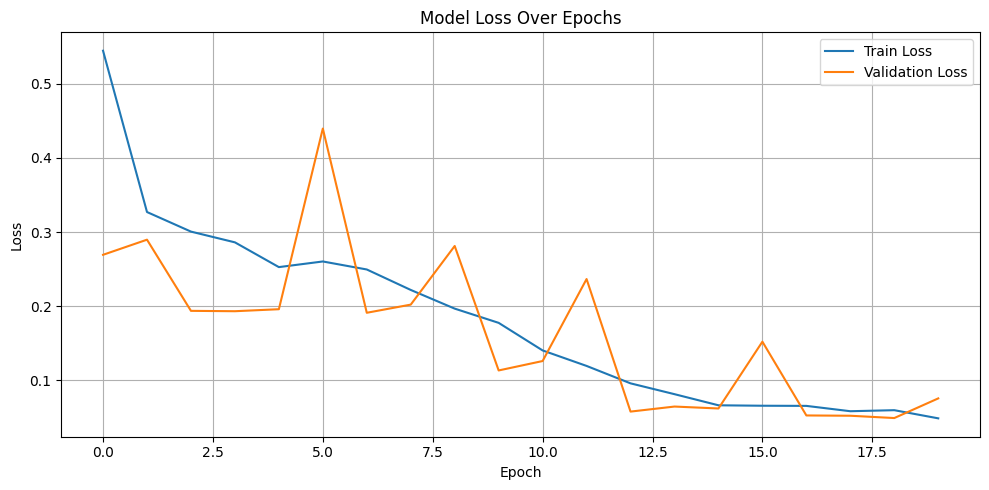

In [16]:
train_loss = [
    0.5447, 0.3271, 0.3007, 0.2862, 0.2528, 0.2604, 0.2496, 0.2220, 0.1968, 0.1776,
    0.1404, 0.1195, 0.0960, 0.0814, 0.0664, 0.0658, 0.0656, 0.0584, 0.0598, 0.0488
]
val_loss = [
    0.2694, 0.2898, 0.1938, 0.1933, 0.1960, 0.4397, 0.1912, 0.2022, 0.2813, 0.1134,
    0.1261, 0.2367, 0.0579, 0.0647, 0.0621, 0.1522, 0.0527, 0.0523, 0.0492, 0.0757
]

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


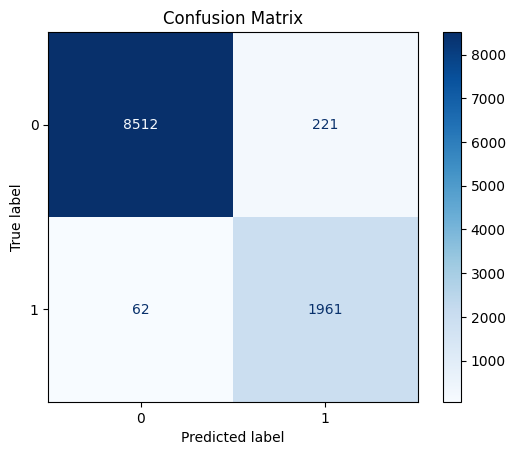

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


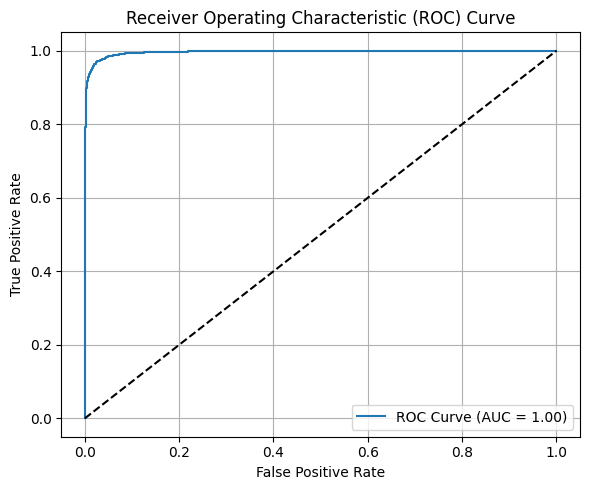

In [18]:
from sklearn.metrics import roc_curve, auc

y_probs = final_model.predict(X_val).ravel()
fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


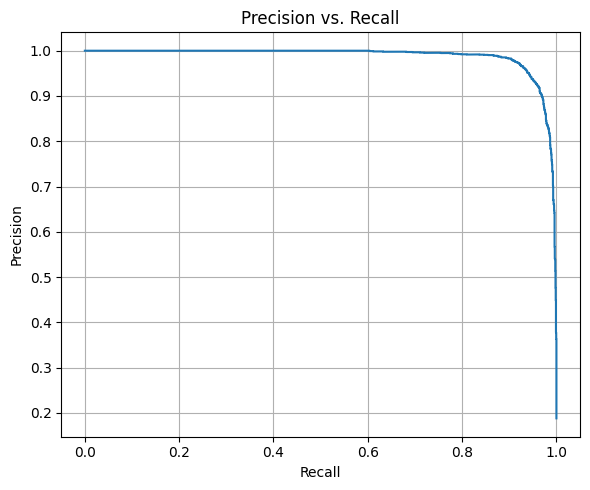

In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_val, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.grid(True)
plt.tight_layout()
plt.show()


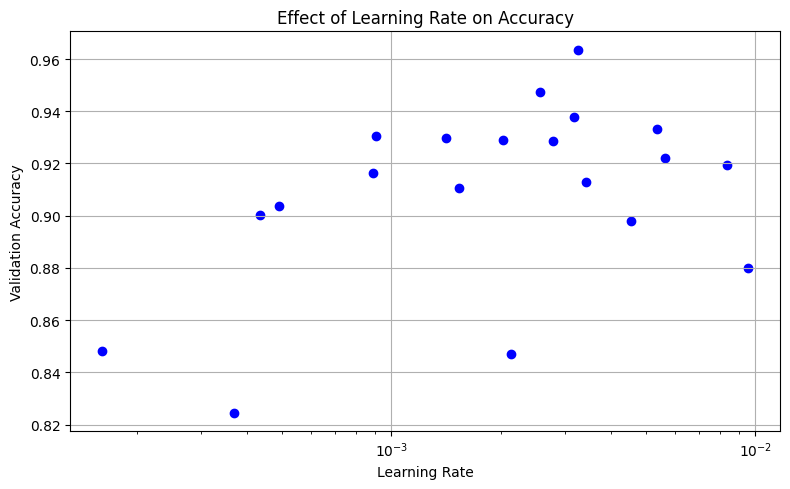

In [20]:
import pandas as pd

df_trials = study.trials_dataframe()
plt.figure(figsize=(8, 5))
plt.scatter(df_trials['params_lr'], df_trials['value'], c='blue')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Learning Rate on Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


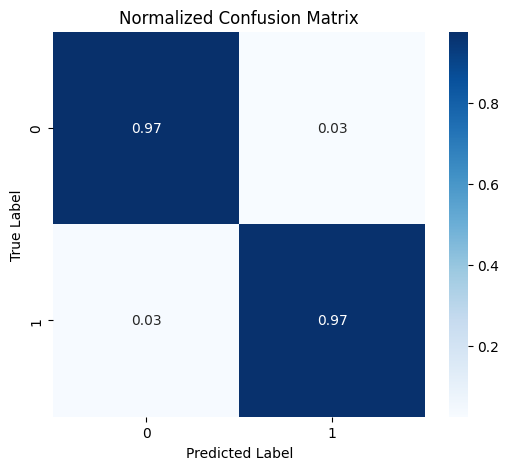

In [21]:
import seaborn as sns

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
!pip install joblib

import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('your_test_data.csv')

features = [
    'op_setting_3', 'T2_fan_inlet_temp', 'T24_LPC_outlet_temp', 'T50_LPT_outlet_temp',
    'P2_fan_inlet_pressure', 'P15_bypass_duct_pressure', 'P30_HPC_outlet_pressure',
    'Nf_fan_speed', 'Nc_core_speed', 'Ps30_HPC_static_pressure',
    'NRf_corrected_fan_speed', 'NRc_corrected_core_speed',
    'BPR_bypass_ratio', 'farB_burner_fuel_air_ratio',
    'htBleed_bleed_enthalpy', 'W32_LPT_coolant_bleed'
]

scaler = joblib.load('minmax_scaler.pkl')
df[features] = scaler.transform(df[features])

def create_sequences(data, seq_len=30):
    X = []
    for eid in data['engine_id'].unique():
        unit = data[data['engine_id'] == eid].sort_values(by='cycle')
        for i in range(len(unit) - seq_len + 1):
            X.append(unit[features].iloc[i:i+seq_len].values)
    return np.array(X)

X_input = create_sequences(df, seq_len=30)

model = load_model('your_saved_model.h5')

# === Step 8: Predict ===
y_pred = (model.predict(X_input) > 0.5).astype(int)

# === Step 9: Show results ===
print("Predicted labels (0 = healthy, 1 = needs maintenance):")
print(y_pred.flatten())
